In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Driver Drowsiness detection using deep learning\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 288 files [00:00, 796.91 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 9 images in output\test\Active Driver
0 folder and 6 images in output\test\Drowsiness
2 folder and 0 images in output\train
0 folder and 126 images in output\train\Active Driver
0 folder and 90 images in output\train\Drowsiness
2 folder and 0 images in output\val
0 folder and 33 images in output\val\Active Driver
0 folder and 24 images in output\val\Drowsiness


In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (100, 100)


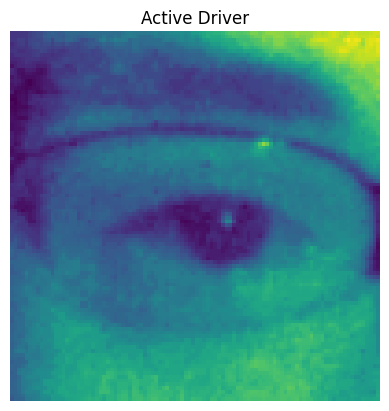

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Active Driver')

Image Shape : (80, 80)


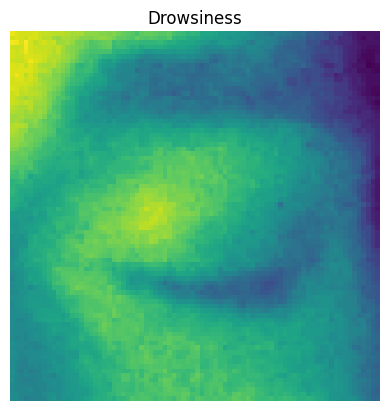

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Drowsiness')

In [9]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [10]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 216 images belonging to 2 classes.
Found 57 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [11]:
train_data.class_indices

{'Active Driver': 0, 'Drowsiness': 1}

In [12]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [13]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (216,)
val_y.shape:  (57,)
test_y.shape:  (15,)


In [14]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [15]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/50


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8711 - loss: 0.4076 - val_accuracy: 0.8947 - val_loss: 0.3162
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.9504 - loss: 0.3054 - val_accuracy: 0.9474 - val_loss: 0.2336
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.9536 - loss: 0.2474 - val_accuracy: 0.9649 - val_loss: 0.1767
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.9712 - loss: 0.1917 - val_accuracy: 0.9825 - val_loss: 0.1381
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.9749 - loss: 0.1611 - val_accuracy: 1.0000 - val_loss: 0.1077
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.9730 - loss: 0.1308 - val_accuracy: 1.0000 - val_loss: 0.0853
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.9640 - loss: 0.1208 - val_accuracy: 1.0000 - val_loss: 0.0697
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.9924 - loss: 0.0984 - val_accuracy: 1.0000 - val_loss: 0.0589
Epoch 9/50
4/4 ━━━━

KeyboardInterrupt: 

In [19]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [24]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        24

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



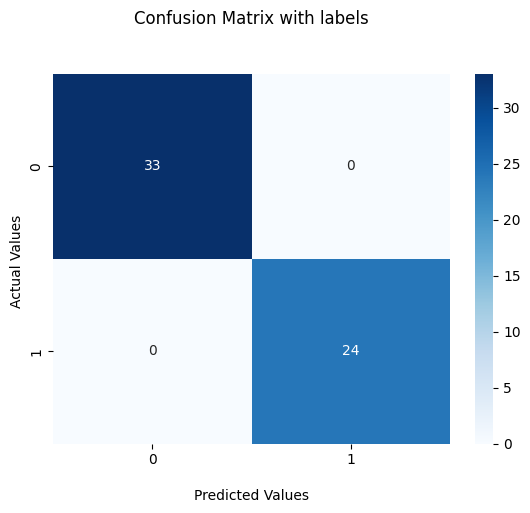

In [25]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



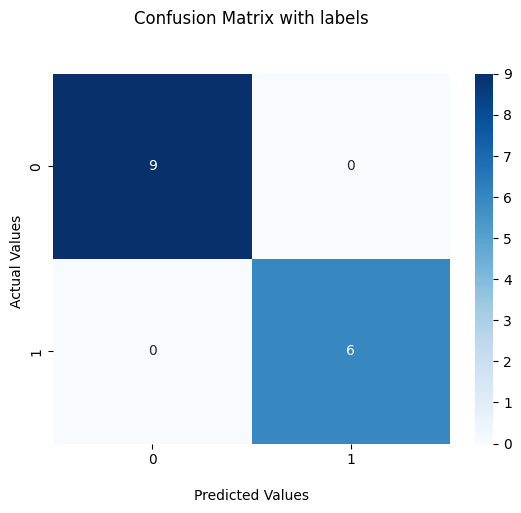

In [27]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
model.save('my_model.keras')

In [29]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Drowsiness


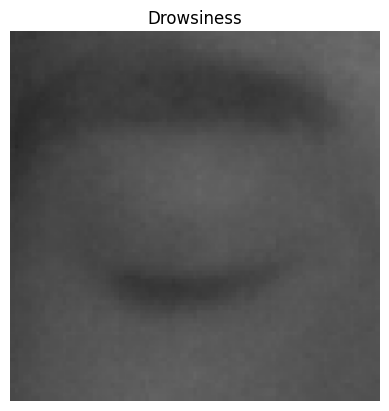

In [31]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Driver Drowsiness detection using deep learning\Dataset\Drowsiness\s0001_00157_0_0_0_0_0_01.png"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Active Driver', 'Drowsiness']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: Active Driver


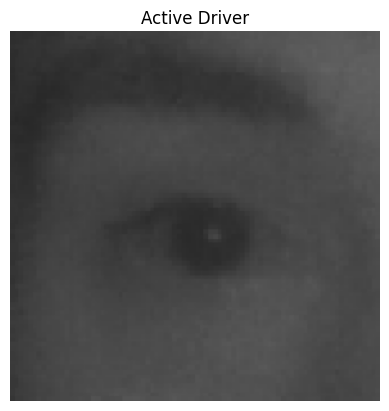

In [32]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Driver Drowsiness detection using deep learning\Dataset\Active Driver\s0001_02379_0_0_1_0_0_01.png"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Active Driver', 'Drowsiness']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


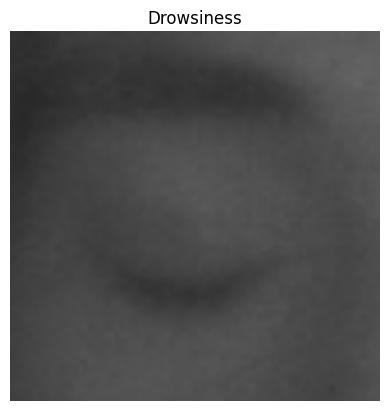

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


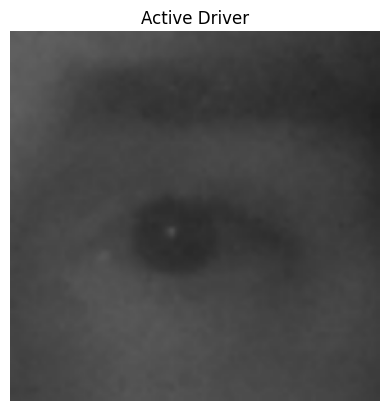

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to classify an image
def classify_image():
    # Load the trained model
    model = load_model('my_model.keras')
    
    # Open a dialog box to select an image file
    file_path = filedialog.askopenfilename(
        title="Select an Image File",
        filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")]
    )
    
    if not file_path:
        print("No file selected.")
        return

    # Load the selected image and ensure it's in RGB mode
    img = Image.open(file_path).convert("RGB")
    img = img.resize((224, 224))  # Resize the image to match model input size

    # Convert image to numpy array and preprocess
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = img_array.reshape(1, 224, 224, 3)

    # Predict the label
    label = model.predict(img_array)

    # Determine the predicted class
    class_names = ['Active Driver', 'Drowsiness']
    predicted_class_index = np.argmax(label)
    predicted_class = class_names[predicted_class_index]

    # Display the image with the predicted label
    plt.imshow(img)
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()

# Create a Tkinter window
root = tk.Tk()
root.title("Drowsiness Detection Classifier")

# Create a button to trigger image classification
classify_button = tk.Button(root, text="Classify Image", command=classify_image)
classify_button.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()


In [1]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('my_model.keras')

# Define class-specific messages
class_messages = {
    0: "You are active.",
    1: "You are drowsy. Please take a break!"
}

# Function to preprocess the image for prediction
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (224, 224))  # Resize to model input size
    frame_array = np.array(frame_resized, dtype="float32") / 255.0  # Normalize
    frame_array = np.expand_dims(frame_array, axis=0)  # Add batch dimension
    return frame_array

# Access the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the webcam.")
else:
    print("Press 'q' to quit the application.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame. Exiting...")
        break

    # Get frame dimensions
    height, width, _ = frame.shape

    # Define ROI coordinates (center rectangle)
    roi_x1 = int(width * 0.3)
    roi_y1 = int(height * 0.3)
    roi_x2 = int(width * 0.7)
    roi_y2 = int(height * 0.7)

    # Draw rectangle on the frame
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)

    # Extract the ROI for prediction
    roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    # Preprocess the ROI
    preprocessed_roi = preprocess_frame(roi)

    # Predict the class (Active or Drowsy)
    predictions = model.predict(preprocessed_roi)
    predicted_class_index = np.argmax(predictions)
    predicted_message = class_messages[predicted_class_index]

    # Display the result on the webcam feed
    cv2.putText(
        frame,
        predicted_message,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )
    cv2.imshow("Drowsiness Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


Press 'q' to quit the application.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178m